In [9]:
import os

import mlflow
import numpy as np
import matplotlib.pyplot as plt

import keras.callbacks
import keras.activations
import keras.optimizers
import keras.losses
from keras.layers import Input, Dense, Dropout, Normalization
from keras.models import Model

from preprocessing.memmap import MemmapSequence, MemmapBatches
from preprocessing.fulldays import FullDaysLoader, DataName
import mlflow_logging
from model_creation.input import build_input_layer, create_norm_layer
from model_creation.mlp import build_mlp_layers, MLPData

os.environ["CUDA_VISIBLE_DEVICES"]="6"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

In [10]:
train_loader = FullDaysLoader([
    "20060315", "20060515", "20060615",
    "20060715", "20060915",
    "20061015", "20061115", "20061215",
])

val_loader = FullDaysLoader(["20060815"])
test_loader = FullDaysLoader(["20060803"])

hsel_train = train_loader.get_data(DataName.hsel)
hsel_val = val_loader.get_data(DataName.hsel)
hsel_test = test_loader.get_data(DataName.hsel)

# noises = np.load("/data/nature_run/work/data/noises.npz")
# print(list(noises.keys()))
# print(noises['h1'].shape)
# sum([noises[key].shape[0] for key in list(noises.keys())[2:]])

In [11]:
mlflow.set_tracking_uri("http://localhost:8011")
current_run = mlflow_logging.start_run("Autoencoders", log_datasets=False)
# mlflow_logging.log_dataset([hsel_train.get_shape()], hsel_train.get_shape(), "HSEL", "Train")
# mlflow_logging.log_dataset([hsel_test.get_shape()], hsel_test.get_shape(), "HSEL", "Test")

2024/09/10 15:48:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/09/10 15:48:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [27]:
input_layer = build_input_layer(hsel_train)
# input_layer = create_norm_layer(hsel_train, mean=251.99, variance=537.84)(input_layer)
encoder = Normalization(mean=251.99, variance=537.84)(input_layer) 
encoder = (Dense(128, keras.activations.relu)(encoder))
decoder = (Dense(1957, keras.activations.linear)(encoder))
autoencoder = Model(input_layer, decoder)
encoder = Model(input_layer, encoder)

autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MAE)
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1957)]            0         
                                                                 
 normalization_4 (Normalizat  (None, 1957)             0         
 ion)                                                            
                                                                 
 dense_10 (Dense)            (None, 128)               250624    
                                                                 
 dense_11 (Dense)            (None, 1957)              252453    
                                                                 
Total params: 503,077
Trainable params: 503,077
Non-trainable params: 0
_________________________________________________________________


In [28]:
train_batches = MemmapBatches(features=[hsel_train], target=hsel_train, batch_size=2048)
val_batches = MemmapBatches(features=[hsel_val], target=hsel_val, batch_size=2048)

early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)
autoencoder.fit(train_batches, validation_data=val_batches, epochs=50, verbose=1, callbacks=[early_stopping]) # also hook up MLFlow!!

2024/09/10 16:37:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '042f59c5814b46db924d42cb693c3384', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50
3776/3776 [==============================] - 104s 28ms/step - loss: 9.3878 - val_loss: 9.2477
Epoch 2/50
3776/3776 [==============================] - 102s 27ms/step - loss: 4.3907 - val_loss: 4.3604
Epoch 3/50
3776/3776 [==============================] - 105s 28ms/step - loss: 3.3165 - val_loss: 2.3498
Epoch 4/50
3776/3776 [==============================] - 101s 27ms/step - loss: 2.8826 - val_loss: 4.2422
Epoch 5/50
3776/3776 [==============================] - 93s 25ms/step - loss: 2.6040 - val_loss: 1.8223
Epoch 6/50
3776/3776 [==============================] - 107s 28ms/step - loss: 2.3707 - val_loss: 1.6191
Epoch 7/50
3776/3776 [==============================] - 99s 26ms/step - loss: 2.2048 - val_loss: 1.6469
Epoch 8/50
3776/3776 [==============================] - 99s 26ms/step - loss: 2.1168 - val_loss: 1.4863
Epoch 9/50
3776/3776 [==============================] - 103s 27ms/step - loss: 1.9524 - val_loss: 1.8847
Epoch 10/50
3776/3776 [==============================] - 9

2024/09/10 17:20:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-mule-192 at: http://localhost:8011/#/experiments/729460346878382676/runs/042f59c5814b46db924d42cb693c3384.
2024/09/10 17:20:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8011/#/experiments/729460346878382676.


KeyboardInterrupt: 

In [29]:
autoencoder.save("hsel128_ae.keras")
encoder.save("hsel128_enc.keras")

In [30]:
# autoencoder = keras.models.load_model("hsel128_ae.keras")

TEST DATASET
----------------------------- INDEX 678016 -----------------------------
MAE: 0.8409027494887642


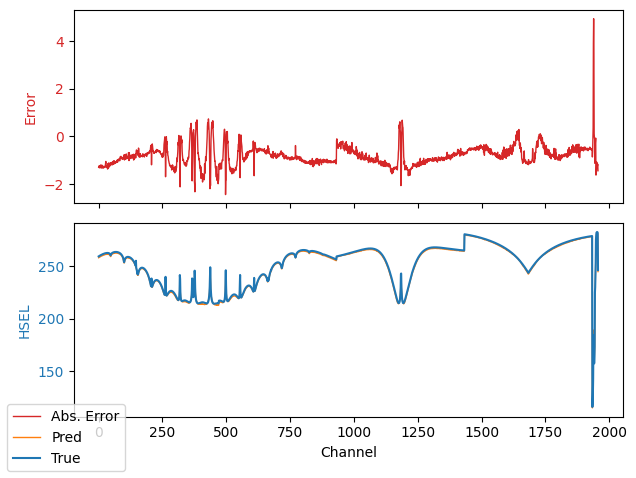

----------------------------- INDEX 789162 -----------------------------
MAE: 0.27613985469079294


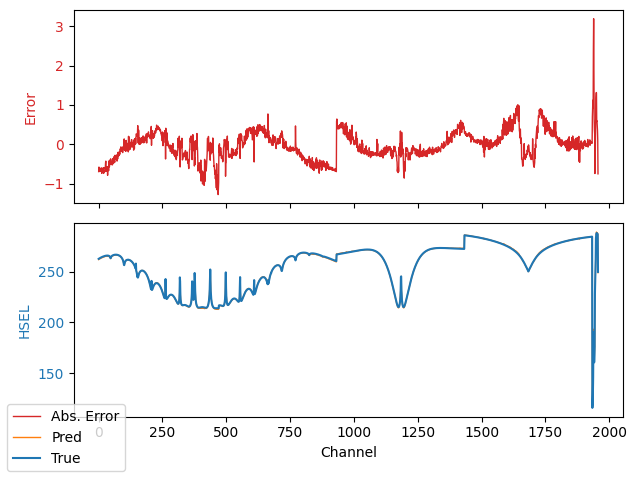

----------------------------- INDEX 908230 -----------------------------
MAE: 1.754538479693788


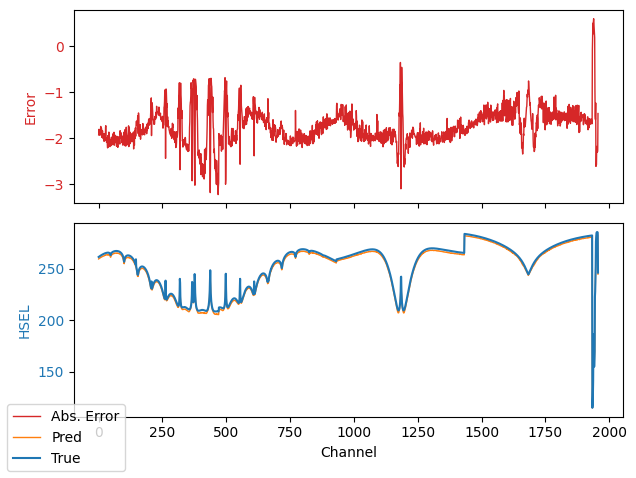

----------------------------- INDEX 178967 -----------------------------
MAE: 2.004459044362235


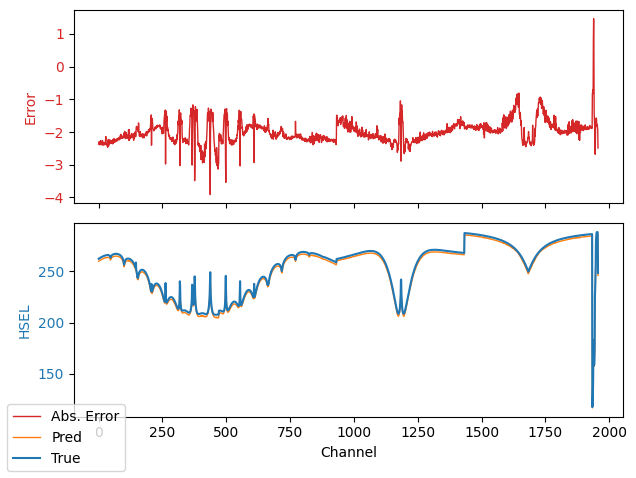

----------------------------- INDEX 683225 -----------------------------
MAE: 1.613460686192344


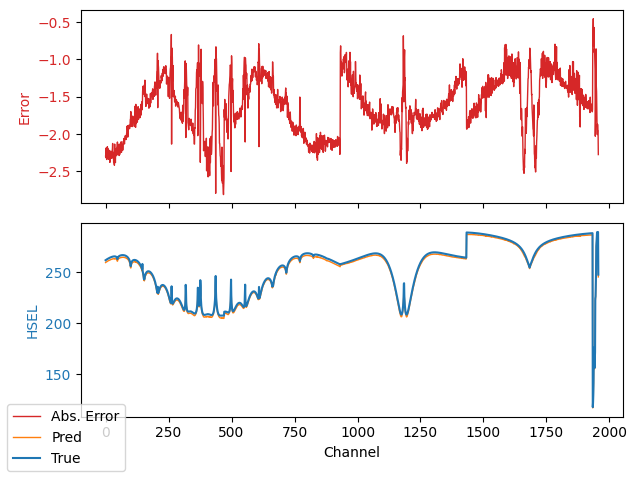

TRAIN DATASET
----------------------------- INDEX 3791810 -----------------------------
MAE: 0.8791875000187129


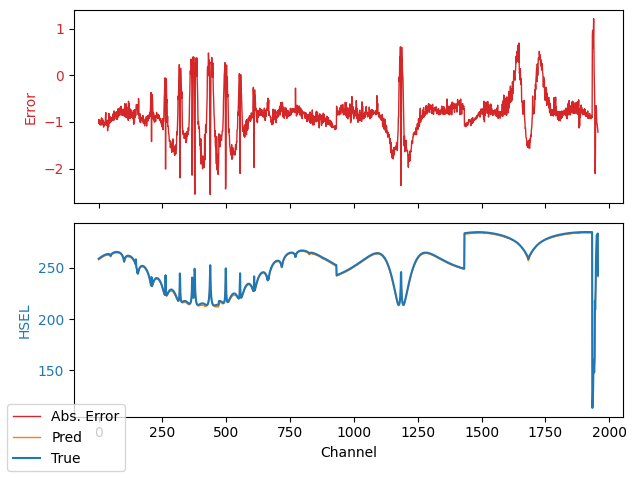

----------------------------- INDEX 3652373 -----------------------------
MAE: 3.295908089799837


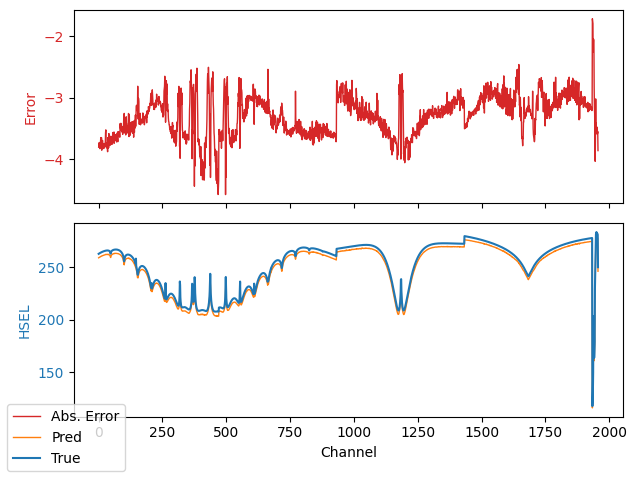

----------------------------- INDEX 5023310 -----------------------------
MAE: 0.7161759057966491


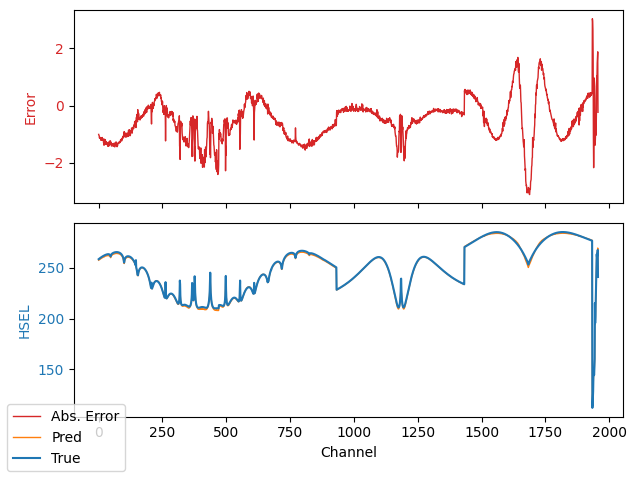

----------------------------- INDEX 5407315 -----------------------------
MAE: 0.260848233498489


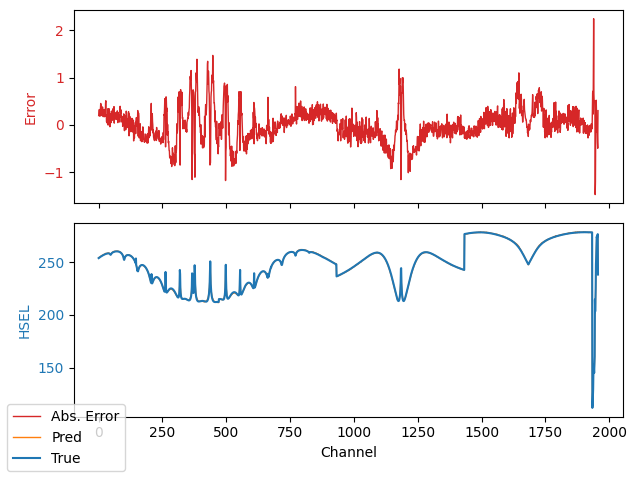

----------------------------- INDEX 6722594 -----------------------------
MAE: 2.7396683675587643


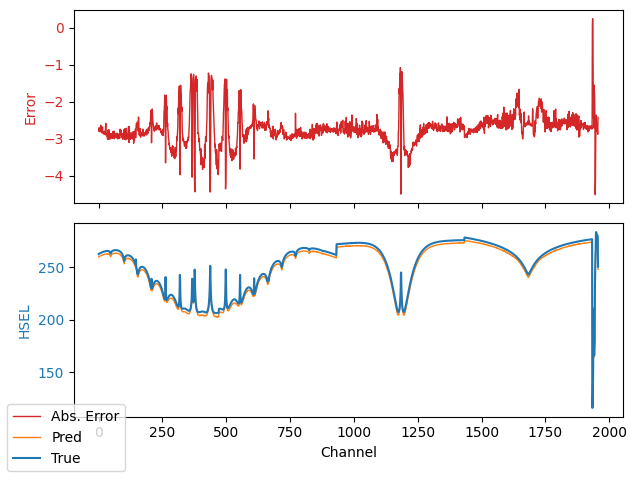

In [31]:
def show_pred_v_true(model: Model, input_data: MemmapSequence, true_data: MemmapSequence):
    rng = np.random.default_rng()
    index = rng.choice(len(input_data))

    print(f"----------------------------- INDEX {index} -----------------------------")
    pred = model.predict(input_data[index:index+1], verbose=0)[0]
    true = true_data[index]

    err = pred - true
    print(f"MAE: {np.average(np.abs(err))}")

    fig, (err_ax, pred_ax) = plt.subplots(2, 1, sharex=True)

    color = 'tab:red'
    err_ax.set_ylabel('Error', color=color)  # we already handled the x-label with ax1
    err_ax.plot(err, color=color, label="Abs. Error", linewidth=1)
    err_ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:blue'
    pred_ax.set_xlabel('Channel')
    pred_ax.set_ylabel('HSEL', color=color)
    pred_ax.plot(pred, color='tab:orange', label="Pred", linewidth=1)
    pred_ax.plot(true, color=color, label="True", linewidth=1.5)
    pred_ax.tick_params(axis='y', labelcolor=color)

    fig.legend(loc="lower left")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

print("TEST DATASET")
for i in range(5):
    show_pred_v_true(autoencoder, hsel_test, hsel_test)

print("TRAIN DATASET")
for i in range(5):
    show_pred_v_true(autoencoder, hsel_train, hsel_train)

mlflow.end_run()